# Kaggle Project Submission Form | Spring 2019 CSC 665 

Habtom Asfaha, Antonio Carmona, Patrick Wong
https://github.com/deftlypatrick/csc665-kaggle-project


## 1. Dataset and Metrics

1. Is it image, text processing, tabular dataset, etc.?

The data set that we used is a tabular dataset containing information that describes the attributes of a number of houses that were sold in Ames, Iowa.

2. What metrics does Kaggle use to evaluate this competition? Provide exact formulas, and your implementation, or refer to the existing API (NumPy, Pytorch, etc.)

According to the competition’s description, prediction submissions are evaluated by calculating the root-mean-squared-error (RMSE) between the natural log applied to each predicted value and the natural log applied to each actual value. The closer that a score is to zero, the better it is. This method was claimed to be chosen over regular RMSE because taking logs results in errors in predicting the values of expensive houses affecting the score as much as errors in predicting the values of cheap houses.

The log RMSE is first calculated by applying the natural log to every predicted value and every actual value. Following this, the new actual values are subtracted from the new predicted values to get error values. The error values are squared, and the mean of the squared error values is calculated. This is the MSE. Finally, the square root of this value is calculated in order to obtain the log RMSE.

In order to implement this evaluation, we simply modified the parameters that our existing RMSE method in our metrics package takes in. 

    def mse(y_predicted, y_true):

        # return mean squared error
        return ((y_predicted - y_true) ** 2).mean()

    def rmse(y_predicted, y_true):

        # return root mean squared error
        return np.sqrt(mse(y_predicted, y_true))

    def rmse_log(y_predicted, y_true):
    
        # calculate the RMSE of the natural log applied element-wise to y_predicted and y_true
        log_rmse = mt.rmse(np.log(y_predicted), np.log(y_true))
    
        return log_rmse

3. How many samples does the entire dataset have?

The entire dataset has 2919 samples in total, and the data set is already split into a train set and test set. There are 1460 samples in the provided train set, and 1459 samples in the provided test set (a nearly even split of the full data set).

4. How many features?

Each sample has 79 features. These features describe the attributes of each house (sample), with a few examples of features being lot area, house style, and the type of foundation that a house has. The value that we are attempting to predict based off of these features is the amount of money that each house will sell for. Our predictions are compared to the real observed values that each house sold for.

5. What's the highest test score your achieved on Kaggle (the **actual score value**, not your leaderboard position).

0.14856


## 2. Model Selection

1. What algorithms have you chosen? If you've tried multiple models, list them all. Describe your reasoning for choosing these particular models.

The algorithms we tried out were Linear Regression, Decision Tree Regression, and Random Forest Regression. Because the values that we need to predict for this competition are continuous, this is a regression problem (meaning that we could rule out using any classification models). We used both our own implementations of these models and the classes provided by scikit-learn both to compare how closely they stacked up and to see which ones would do a better job of making predictions.

Due to some of the features describing attributes that only a select number of samples have (e.g. pool area, because not all houses have pools), we decided to convert NaN values to zeroes instead of removing the samples containing NaN values from the set (as that would have resulted in many of the less expensive homes being removed).

We ended up using Random Forest Regression in the end because the train and test scores we received with just the default settings were notably better than other methods.

2. What are the best hyper-parameter settings you've found (e.g. the number of trees, any regularization, sampling ratio, learning rate, the size of the NN, etc.)

In general, n_jobs was set to -1 when possible in order to use all processors to speed up fitting and predicting by running jobs in parallel for fit and predict.

For Random Forest Regression, increasing the number of trees (n_estimators) up to a certain point resulted in the score improving. Many different values were tested with both the training set and test set, and it was found that the test score reaches its lowest value (~0.148) when n_estimators is around 500. Increasing or decreasing the number of estimators by increments of 100 from this point results in the score becoming worse.

Increasing the minimum number of samples required for a split or the minimum number of samples required to be a leaf (min_samples_split and min_samples_leaf) from their default values of 2 and 1 both resulted in scores becoming worse as the values increased.

Setting a fixed maximum depth resulted in a worse score than not setting a maximum depth, but changing the maximum value around did not result in a large amount of score variance.

For the Decision Tree Regressor, increasing or decreasing the maximum depth over 100 will make the score worse and changing the minimum number of samples required to be a leafleaves that is not 2 will also make the score worse. 

This suggests that the best decision tree is reached at the max_depth of 100 and the min_sample_leaves at 2 which is the most standard approach to the dataset. 


## 3. Training & Validation

1. What is your training and test split approach?

Due to the format of the dataset (the training set and test set were provided to us pre-split), we were unable to manually shuffle and split the full data set. The training and test sets we were given were split nearly 1:1 (the test set has one less sample than the training set) and do not appear to be sorted by any of the samples’ features.

If we did have to split the training and test sets manually, we would have done so by shuffling the full data set and then splitting with a ratio such as 2:1 (66% training set, 33% test set) in order to avoid having our training set sorted in any way and to have a good variety of samples to train on (since having more samples in our training set would reduce the chances of something unexpected for our model showing up in the test set).

2. What methods did you use to evaluate your performance on your datasets. Provide the exact formula and the implementation, or refer to an existing API.

To evaluate the performance of our dataset, we used both RMSE with the logarithms of values (which is the formula used by Kaggle to evaluate this competition) and RSQ. With the RMSE of logarithms, the goal is a score closest to zero. With RSQ, values closest to one are best. 

    def mse(y_predicted, y_true):

        # return mean squared error
        return ((y_predicted - y_true) ** 2).mean()

    def rmse(y_predicted, y_true):

        # return root mean squared error
        return np.sqrt(mse(y_predicted, y_true))

    def rmse_log(y_predicted, y_true):
    
        # calculate the RMSE of the natural log applied element-wise to y_predicted and y_true
        log_rmse = mt.rmse(np.log(y_predicted), np.log(y_true))
    
        return log_rmse
        
    def rsq(y_predicted, y_true):

        # return score
        v = ((y_true - y_true.mean()) ** 2).mean()
        return 1 - mse(y_predicted, y_true) / v

   2.1 What is the best score you've achieved?   
   
Our best train scores are as follows.

    Log RMSE: 0.05841479022158461
    RSQ: 0.9820542250900609

## 4. Your Code

In [155]:
# Data Download Link: https://www.kaggle.com/c/5407/download-all

In [156]:
import numpy as np
import pandas as pd
import csc665.features as ft
import csc665.metrics as mt
from csc665.ensemble import RandomForestRegressor as our_rfr
from sklearn.ensemble import RandomForestRegressor as sk_rfr

In [157]:
def preprocess_train(csv_df, target_col_name):
    
    # replace all NA values with zero
    csv_df_temp = csv_df.copy().fillna(0)
    
    # convert all strings to numbers
    string_columns = list(csv_df_temp.select_dtypes(exclude='number'))
    ft.create_categories(csv_df_temp, string_columns)
    
    # split the data frame into x and y
    csv_df_x = csv_df_temp.drop(target_col_name, axis=1)
    csv_df_y = csv_df_temp[target_col_name].values
    
    return csv_df_x, csv_df_y

In [158]:
def preprocess_test(csv_df):
    
    # replace all NA values with zero
    csv_df_temp = csv_df.copy().fillna(0)
    
    # convert all strings to numbers
    string_columns = list(csv_df_temp.select_dtypes(exclude='number'))
    ft.create_categories(csv_df_temp, string_columns)
    
    return csv_df_temp

In [159]:
def rmse_log(y_predicted, y_true):
    
    # calculate the RMSE of the natural log applied element-wise to y_predicted and y_true
    log_rmse = mt.rmse(np.log(y_predicted), np.log(y_true))
    
    return log_rmse

In [160]:
# read CSV files
train_df = pd.read_csv("data/train.csv")
test_df = pd.read_csv("data/test.csv")

FileNotFoundError: [Errno 2] File b'data/train.csv' does not exist: b'data/train.csv'

In [161]:
# preprocess and split train set into x and y, replace all NaN elements with 0
x_train_df, y_train_df = preprocess_train(train_df, "SalePrice")

# convert all strings in test set to numbers, replace all NaN elements with 0
x_test_df = preprocess_test(test_df)

# Our Random Forest Library

In [147]:
# fit our random forest regressor
ours = our_rfr(10, 0.4)
ours.fit(x_train_df, y_train_df)

In [148]:
# predict and score (train set)
ours_prediction_train = ours.predict(x_train_df)
ours_score_train = mt.rsq(ours_prediction_train, y_train_df)
ours_rmse_log_train = rmse_log(ours_prediction_train, y_train_df)
print("Log RMSE: ", ours_rmse_log_train)
print("RSQ: ", ours_score_train)

Log RMSE:  0.11568219492658534
RSQ:  0.9251546917272753


In [149]:
# predict (test set)
ours_prediction_test = ours.predict(x_test_df)

# scikit-learn's Random Forest Library

In [150]:
# fit scikit-learn's random forest regressor
sk = sk_rfr(n_estimators=500, n_jobs=-1)
sk.fit(x_train_df, y_train_df)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [151]:
# predict and score (train set)
sk_prediction_train = sk.predict(x_train_df)
sk_score_train = sk.score(x_train_df, y_train_df)
sk_rmse_log_train = rmse_log(sk_prediction_train, y_train_df)
print("Log RMSE: ", sk_rmse_log_train)
print("RSQ: ", sk_score_train)

Log RMSE:  0.058585506052791565
RSQ:  0.9818653022577345


In [152]:
# predict (test set)
sk_prediction_test = sk.predict(x_test_df)

# Submission

In [153]:
# output predictions from both our random forest regressor and scikit-learn's random forest regressor
sk_predictions = pd.DataFrame({'Id': x_test_df.Id, 'SalePrice': sk_prediction_test})
sk_predictions.to_csv('submission_sk.csv', index=False)
our_predictions = pd.DataFrame({'Id': x_test_df.Id, 'SalePrice': ours_prediction_test})
our_predictions.to_csv('submission_665.csv', index=False)

# Final Output

TRAIN SCORE
Log RMSE:  0.058585506052791565
RSQ:  0.9251546917272753
TEST SCORE


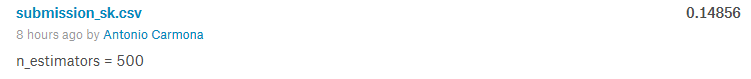

In [154]:
print("TRAIN SCORE")
# Log RMSE
if sk_rmse_log_train < ours_rmse_log_train:
    print("Log RMSE: ", sk_rmse_log_train)
else:
    print("Log RMSE: ", ours_rmse_log_train)

# RSQ
if sk_score_train < ours_score_train:
    print("RSQ: ", sk_score_train)
else:
    print("RSQ: ", ours_score_train)
    
print("TEST SCORE")

from IPython.display import Image
Image(filename='test_score.png') 